# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name="out_layer")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation='relu')
    x = self.layer2(x, activation='relu')
    x = self.out_layer(x, activation='softmax')

    return x

In [ ]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()
    # Отримання індексів максимальних значень у кожному рядку передбачень
    y_pred_classes = tf.argmax(y_pred, axis=1)

    # Порівняння передбачених класів з істинними класами
    correct_predictions = tf.equal(y_pred_classes, y_true)

    # Обчислення частки правильних передбачень
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy

In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [ ]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)

        # Перетворюємо batch_y на int64
        batch_y = tf.cast(batch_y, tf.int64)

        current_accuracy = accuracy(pred, batch_y)

        # Зберігаємо поточну помилку та точність
        loss_history.append(current_loss.numpy())
        accuracy_history.append(current_accuracy.numpy())

        # Виводимо інформацію про поточний стан тренування
        print(f"Step: {step}, Loss: {current_loss.numpy()}, Accuracy: {current_accuracy.numpy()}")

Step: 100, Loss: 588.7703857421875, Accuracy: 0.1015625
Step: 200, Loss: 588.7899169921875, Accuracy: 0.1484375
Step: 300, Loss: 586.041015625, Accuracy: 0.09765625
Step: 400, Loss: 584.8748779296875, Accuracy: 0.11328125
Step: 500, Loss: 579.19482421875, Accuracy: 0.171875
Step: 600, Loss: 575.1488647460938, Accuracy: 0.17578125
Step: 700, Loss: 557.798828125, Accuracy: 0.23046875
Step: 800, Loss: 532.0556030273438, Accuracy: 0.234375
Step: 900, Loss: 496.3244323730469, Accuracy: 0.26171875
Step: 1000, Loss: 494.25042724609375, Accuracy: 0.26171875
Step: 1100, Loss: 466.2452697753906, Accuracy: 0.2890625
Step: 1200, Loss: 471.0740661621094, Accuracy: 0.33203125
Step: 1300, Loss: 445.4723815917969, Accuracy: 0.30078125
Step: 1400, Loss: 446.7608947753906, Accuracy: 0.28125
Step: 1500, Loss: 435.52239990234375, Accuracy: 0.35546875
Step: 1600, Loss: 452.29718017578125, Accuracy: 0.39453125
Step: 1700, Loss: 416.4639892578125, Accuracy: 0.359375
Step: 1800, Loss: 432.1439208984375, Accur

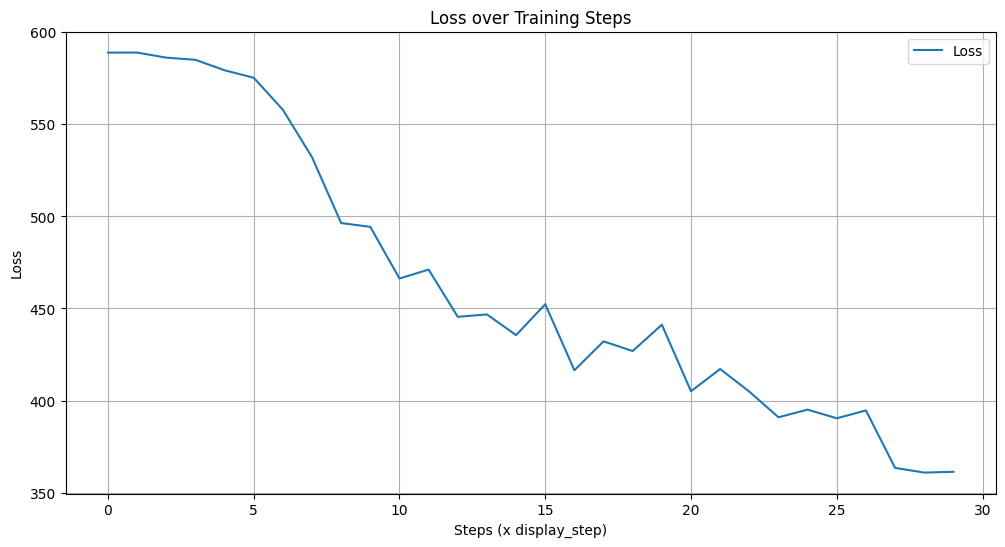

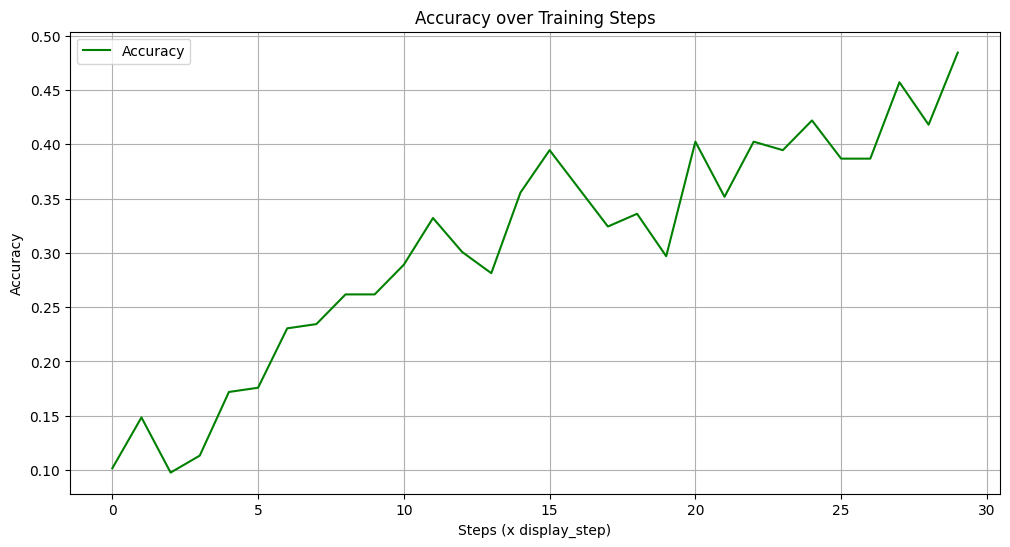

In [ ]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label='Loss')
plt.xlabel('Steps (x display_step)')
plt.ylabel('Loss')
plt.title('Loss over Training Steps')
plt.legend()
plt.grid(True)
plt.show()

# Виведіть графік точності
plt.figure(figsize=(12, 6))
plt.plot(accuracy_history, label='Accuracy', color='green')
plt.xlabel('Steps (x display_step)')
plt.ylabel('Accuracy')
plt.title('Accuracy over Training Steps')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Обчисліть точність навченої нейромережі
# Отримуємо передбачення моделі на тестових даних
test_predictions = neural_net(x_test)

# Перетворюємо y_test на int64
y_test = tf.cast(y_test, tf.int64)

# Тестування моделі на тестових даних
test_accuracy = accuracy(test_predictions, y_test)

print(f"Test Accuracy: {test_accuracy.numpy()}")

Test Accuracy: 0.4697999954223633


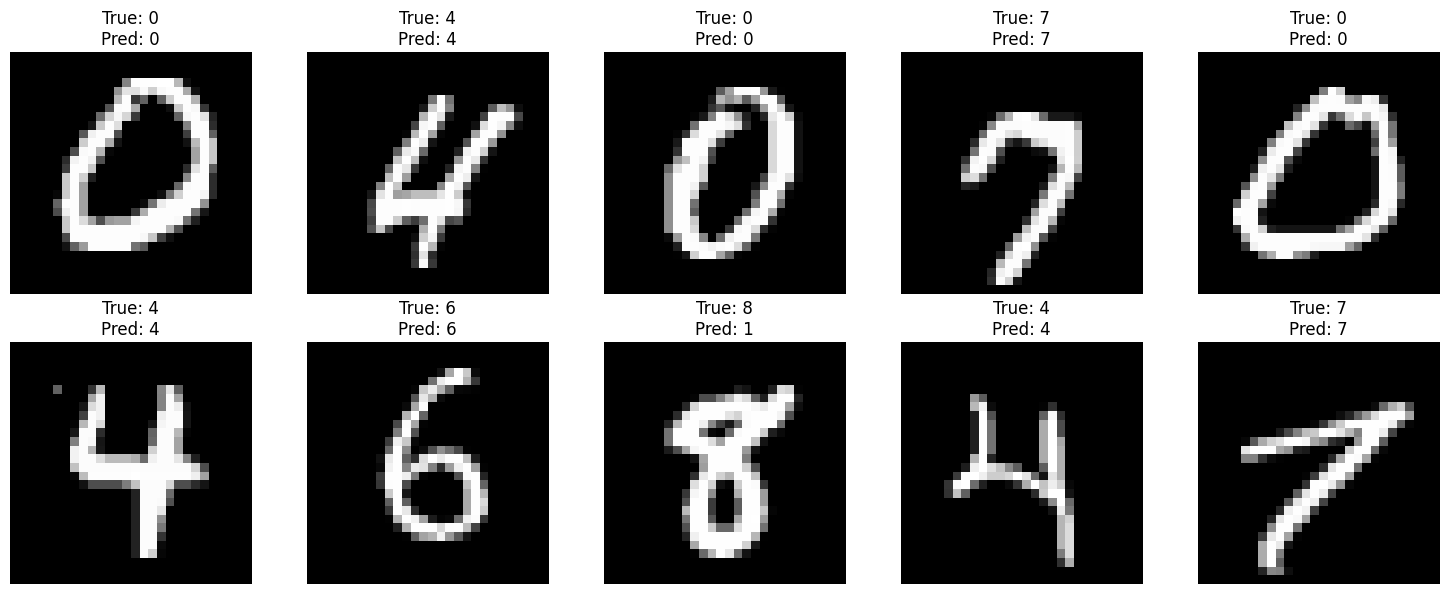

Number of errors: 1 out of 10
Error rate: 10.00%


In [ ]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Вибираємо 5 випадкових індексів з тестової вибірки
random_indices = np.random.choice(x_test.shape[0], 5, replace=False)
random_indices = tf.convert_to_tensor(random_indices, dtype=tf.int64)

# Вибираємо 5 випадкових зображень та їх істинних міток
random_images = tf.gather(x_test, random_indices)
random_labels = tf.gather(y_test, random_indices)

# Додаємо 5 довільних зображень з тестової вибірки
additional_indices = np.random.choice(x_test.shape[0], 5, replace=False)
additional_indices = tf.convert_to_tensor(additional_indices, dtype=tf.int64)
additional_images = tf.gather(x_test, additional_indices)
additional_labels = tf.gather(y_test, additional_indices)

# Об'єднуємо вибрані зображення та мітки
test_images = tf.concat([random_images, additional_images], axis=0)
test_labels = tf.concat([random_labels, additional_labels], axis=0)

# Отримуємо передбачення моделі на вибраних зображеннях
test_predictions = neural_net(test_images)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Виводимо зображення та передбачення моделі
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].numpy().reshape(28, 28), cmap='gray')
    plt.title(f"True: {test_labels[i].numpy()}\nPred: {test_predicted_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Обчислюємо кількість помилок
errors = np.sum(test_labels.numpy() != test_predicted_labels)
print(f"Number of errors: {errors} out of 10")
print(f"Error rate: {errors / 10 * 100:.2f}%")

:Це означає, що моя нейронна мережа помилилася у 1 випадку з 10 тестових зображень, що дає похибку 10%.